In [1]:
# Install required libraries
%pip install transformers datasets sentencepiece nltk
%pip install py7zr
%pip install pd
%pip install evaluate
%pip install rouge_score

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import torch
from transformers import pipeline, AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize
from collections import Counter
import seaborn as sns
import pandas as pd
import evaluate


C:\Users\aayon\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Ensure GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load SAMSum dataset
dataset = load_dataset("Samsung/samsum",trust_remote_code=True)
train_data = dataset['train']
valid_data = dataset['validation']
test_data = dataset['test']

{'id': '13818513', 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)", 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}


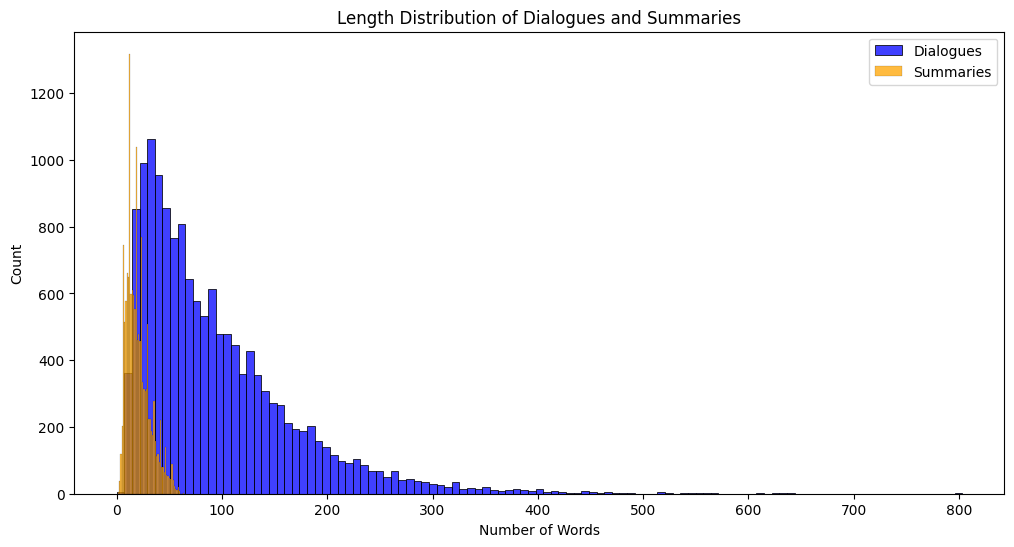

In [5]:
# Check the structure of the first entry in the dataset
print(train_data[0])

# (b) Plot the Length Distribution of Dialogues and Summaries
dialogue_lengths = [len(dialogue['dialogue'].split()) for dialogue in train_data]
summary_lengths = [len(dialogue['summary'].split()) for dialogue in train_data]

# Plot the length distributions
plt.figure(figsize=(12, 6))
sns.histplot(dialogue_lengths, color='blue', label='Dialogues')
sns.histplot(summary_lengths, color='orange', label='Summaries')
plt.title("Length Distribution of Dialogues and Summaries")
plt.xlabel("Number of Words")
plt.legend()
plt.show()

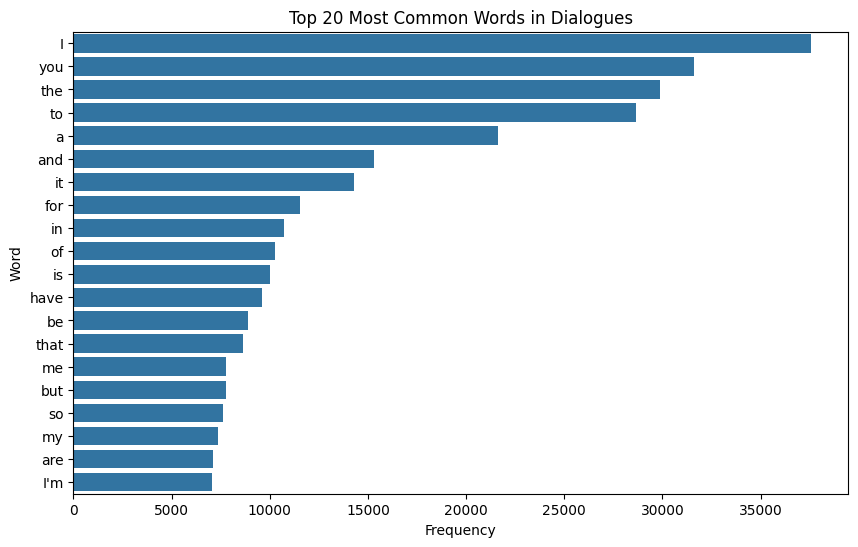

In [6]:
# (c) 20 Most Common Words in Dialogues
all_dialogue_words = ' '.join([dialogue['dialogue'] for dialogue in train_data]).split()
common_words = Counter(all_dialogue_words).most_common(20)
# Convert the results to a DataFrame for better plotting with Seaborn
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Plot the top 20 most common words using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=df_common_words)
plt.title("Top 20 Most Common Words in Dialogues")
plt.show()



In [7]:
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")

c:\Users\aayon\anaconda3\envs\llm2\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Inference with Pre-trained Models
# Load Pre-trained Models (e.g., BART, T5)
models = ["facebook/bart-base", "t5-small", "google/pegasus-xsum"]
model_pipelines = {}

for model_name in models:
    print(f"Loading model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
    summarizer = pipeline("summarization", model=model, tokenizer=tokenizer, device='cuda')
    model_pipelines[model_name] = summarizer

Loading model: facebook/bart-base
Loading model: t5-small
Loading model: google/pegasus-xsum


In [9]:
# Generate summaries for a few dialogues and compare
sample_dialogues = [train_data[i]['dialogue'] for i in range(3)]
for model_name, summarizer in model_pipelines.items():
    print(f"\nSummaries using {model_name}:\n")
    for dialogue in sample_dialogues:
        summary = summarizer(dialogue, max_length=50, min_length=10, do_sample=False)
        print(f"Dialogue: {dialogue}\nSummary: {summary[0]['summary_text']}\n")


Your max_length is set to 50, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)



Summaries using facebook/bart-large-cnn:



c:\Users\aayon\anaconda3\envs\llm2\Lib\site-packages\transformers\models\bart\modeling_bart.py:496: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Your max_length is set to 50, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Dialogue: Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)
Summary: Amanda: I baked  cookies. Do you want some? Jerry: Sure!

Dialogue: Olivia: Who are you voting for in this election? 
Oliver: Liberals as always.
Olivia: Me too!!
Oliver: Great
Summary: Olivia asks Oliver who he is voting for in the election. Oliver says he's voting for Liberals as always. Olivia asks him who he will be voting for.



Your max_length is set to 50, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Dialogue: Tim: Hi, what's up?
Kim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating
Tim: What did you plan on doing?
Kim: Oh you know, uni stuff and unfucking my room
Kim: Maybe tomorrow I'll move my ass and do everything
Kim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies
Tim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores
Tim: It really helps
Kim: thanks, maybe I'll do that
Tim: I also like using post-its in kaban style
Summary: Kim: I was going to do lots of stuff but ended up procrastinating. Tim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores. Kim: Maybe tomorrow I'll move my ass and do


Summaries using t5-large:



Your max_length is set to 50, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Dialogue: Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)
Summary: Amanda: i baked cookies. do you want some? Jerry: sure! :-)

Dialogue: Olivia: Who are you voting for in this election? 
Oliver: Liberals as always.
Olivia: Me too!!
Oliver: Great
Summary: liberals as always - who are you voting for in this election? olivia: 'liberals as always'



Your max_length is set to 50, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Dialogue: Tim: Hi, what's up?
Kim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating
Tim: What did you plan on doing?
Kim: Oh you know, uni stuff and unfucking my room
Kim: Maybe tomorrow I'll move my ass and do everything
Kim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies
Tim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores
Tim: It really helps
Kim: thanks, maybe I'll do that
Tim: I also like using post-its in kaban style
Summary: Kim: i was going to do lots of stuff but ended up procrastinating . for doing stuff i recommend pomodoro technique where u use breaks for doing chores .


Summaries using google/pegasus-large:



Your max_length is set to 50, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Dialogue: Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)
Summary: Amanda: I'll bring you tomorrow :-)

Dialogue: Olivia: Who are you voting for in this election? 
Oliver: Liberals as always.
Olivia: Me too!!
Oliver: Great
Summary: Oliver: Me too!! Olivia: Me too!!

Dialogue: Tim: Hi, what's up?
Kim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating
Tim: What did you plan on doing?
Kim: Oh you know, uni stuff and unfucking my room
Kim: Maybe tomorrow I'll move my ass and do everything
Kim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies
Tim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores
Tim: It really helps
Kim: thanks, maybe I'll do that
Tim: I also like using post-its in kaban style
Summary: Kim: Oh you know, uni stuff and unfucking my room Kim: Maybe tomorrow I'll move my ass and do everything Kim: We were going to defrost a fridge so in

In [10]:
def lead_3_baseline(text):
    sentences = sent_tokenize(text)
    return ' '.join(sentences[:3])

In [11]:
# Evaluate Lead-3 Baseline on the same dialogues
print("\nLead-3 Baseline Summaries:")
for dialogue in sample_dialogues:
    print(f"Dialogue: {dialogue}\nLead-3 Summary: {lead_3_baseline(dialogue)}\n")


Lead-3 Baseline Summaries:
Dialogue: Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)
Lead-3 Summary: Amanda: I baked  cookies. Do you want some? Jerry: Sure!

Dialogue: Olivia: Who are you voting for in this election? 
Oliver: Liberals as always.
Olivia: Me too!!
Oliver: Great
Lead-3 Summary: Olivia: Who are you voting for in this election? Oliver: Liberals as always. Olivia: Me too!!

Dialogue: Tim: Hi, what's up?
Kim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating
Tim: What did you plan on doing?
Kim: Oh you know, uni stuff and unfucking my room
Kim: Maybe tomorrow I'll move my ass and do everything
Kim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies
Tim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores
Tim: It really helps
Kim: thanks, maybe I'll do that
Tim: I also like using post-its in kaban style
Lead-3 Summary: Tim: Hi, what's up?

In [12]:
rouge = evaluate.load("rouge")

In [13]:
# Generate summaries and compute ROUGE for each model
def compute_rouge(reference_summaries, generated_summaries):
    return rouge.compute(predictions=generated_summaries, references=reference_summaries)


In [14]:
# For a quick comparison on the sample dialogues
reference_summaries = [train_data[i]['summary'] for i in range(3)]

# Compute ROUGE scores for each model
for model_name, summarizer in model_pipelines.items():
    generated_summaries = [summarizer(dialogue, max_length=50, min_length=10, do_sample=False)[0]['summary_text'] for dialogue in sample_dialogues]
    rouge_score = compute_rouge(reference_summaries, generated_summaries)
    print(f"\nROUGE Score for {model_name}: {rouge_score}")

Your max_length is set to 50, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 50, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 50, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)



ROUGE Score for facebook/bart-large-cnn: {'rouge1': 0.3549257759784075, 'rouge2': 0.08858505564387918, 'rougeL': 0.2642825011246064, 'rougeLsum': 0.2642825011246064}


Your max_length is set to 50, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 50, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)



ROUGE Score for t5-large: {'rouge1': 0.47007274283269146, 'rouge2': 0.14326622510765732, 'rougeL': 0.3491313649978605, 'rougeLsum': 0.3491313649978605}


Your max_length is set to 50, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)



ROUGE Score for google/pegasus-large: {'rouge1': 0.21346153846153848, 'rouge2': 0.0, 'rougeL': 0.20064102564102568, 'rougeLsum': 0.20064102564102568}


In [15]:
# Lead-3 Baseline ROUGE score
lead_3_summaries = [lead_3_baseline(dialogue) for dialogue in sample_dialogues]
lead_3_rouge_score = compute_rouge(reference_summaries, lead_3_summaries)
print(f"\nLead-3 Baseline ROUGE Score: {lead_3_rouge_score}")



Lead-3 Baseline ROUGE Score: {'rouge1': 0.41475483580746736, 'rouge2': 0.1283461210571185, 'rougeL': 0.34263007947218477, 'rougeLsum': 0.3540260908681961}


In [16]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# Tokenizer and model loading
model_name = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

In [17]:
# Preprocessing the dataset for fine-tuning
def preprocess_function(examples):
    inputs = examples["dialogue"]
    targets = examples["summary"]
    
    # Tokenize inputs and summaries, apply truncation and padding
    model_inputs = tokenizer(inputs, max_length=512, padding='max_length', truncation=True)
    
    # Tokenize labels (summaries) and also apply truncation and padding
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, padding='max_length', truncation=True)
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


# Apply preprocessing to dataset
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]c:\Users\aayon\anaconda3\envs\llm2\Lib\site-packages\transformers\tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 818/818 [00:00<00:00, 3060.36 examples/s]


In [29]:
# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,  
)

In [26]:
import torch
torch.cuda.empty_cache()

In [31]:
# Define the Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
)

# Fine-tune the model
trainer.train()

  0%|          | 4/44196 [00:27<82:21:46,  6.71s/it]

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 12.53 GiB is allocated by PyTorch, and 115.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [1]:
# Evaluate the fine-tuned model
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")


NameError: name 'trainer' is not defined

In [ ]:
# Generate summaries using the fine-tuned model
fine_tuned_summaries = [trainer.model.generate(tokenizer(dialogue, return_tensors="pt").input_ids.to(device)) for dialogue in sample_dialogues]
generated_summaries = [tokenizer.decode(summary[0], skip_special_tokens=True) for summary in fine_tuned_summaries]

# Compute ROUGE for the fine-tuned model
fine_tuned_rouge_score = compute_rouge(reference_summaries, generated_summaries)
print(f"\nFine-tuned Model ROUGE Score: {fine_tuned_rouge_score}")